In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it
import functools as ft
from tools import helpers as h
from copy import copy

from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline

### Read in Super/sub cluster 

In [44]:
louv = pd.read_csv('../data/cluster/louvain_clusters.txt', index_col=0, sep='\t')
louv.columns = ['cluster_super']
louv = louv.merge(pd.read_csv('../data/cluster/louvain_small_clusters.txt', index_col=0, sep='\t'), left_index=True, right_index=True)
louv.columns = ['cluster_super', 'cluster_sub']
louv.head()

,cluster_super,cluster_sub
names,,
MST1R,3,11
YES1,3,11
TYRO3,3,11
FGR,3,11
SRC,3,11


In [2]:
hgnc_mapper = h.fetch_hgnc_mapper()

In [3]:
!ls ../data/grmetrics/

broad_hms_lincs.tsv     genentech_cell_line.tsv lincs_mcf10a.tsv
ctrp.tsv                hms_lincs_density.tsv   mep_lincs.tsv


In [127]:
# initial target list -- not for linear programming
klaeger = pd.read_excel('../data/ref/Klaeger_Science_2017 Supplementary Table 6 Selectivities.xlsx', sheet_name='CATDS target')

# a number of drugs have very similar targets listed in the same row
# we parse to separate these out 
double_drug_targets = klaeger[klaeger['Target'].apply(lambda x: ';' in x)]

# get the first and second gene
first_genes = double_drug_targets['Target'].apply(lambda x: x.split(';')[0])
second_genes = double_drug_targets['Target'].apply(lambda x: x.split(';')[1])

# fix the double targets
repaired_double_targets = double_drug_targets.drop('Target', axis=1).assign(**{'Target':first_genes})
repaired_double_targets = repaired_double_targets.append(double_drug_targets.drop('Target', axis=1).assign(**{'Target':second_genes})) 
klaeger = klaeger.drop(double_drug_targets.index).append(repaired_double_targets, sort=False)

# filter to only hgnc keys
klaeger = klaeger[klaeger.Target.isin(hgnc_mapper.keys())]

# convert to hgnc
klaeger.Target = klaeger.Target.apply(lambda x: hgnc_mapper[x])

# filter to our kinases
klaeger = klaeger[klaeger.Target.isin(set(louv.index))]

# save total drug list information
drug_list = list(sorted(set(klaeger.Drug)))
print(len(drug_list), ' drugs present for our analysis')

# sort columns
klaeger = klaeger[['Target', 'Drug', 'At', 'CATDS']]

klaeger['Drug'] = [x.lower().replace('-', '') for x in klaeger.Drug]
klaeger.head()

217  drugs present for our analysis


,Target,Drug,At,CATDS
0,AURKA,mk5108,0.120921,0.657165
1,CHEK1,pf477736,0.243725,0.733257
2,FLT3,dovitinib,0.265240,0.860803
4,MET,capmatinib,0.337514,1.000000
5,MAPKAPK2,vx702,0.342705,0.743594


In [128]:
klaeger_drugs = set(klaeger.Drug)
print(len(klaeger_drugs), 'drugs in the Klaeger 2017 Science Paper with known targets')

217 drugs in the Klaeger 2017 Science Paper with known targets


In [129]:
datasets = ['broad_hms_lincs.tsv', 'genentech_cell_line.tsv', 
            'lincs_mcf10a.tsv', 'ctrp.tsv',
            'hms_lincs_density.tsv', 'mep_lincs.tsv']

abbrevs = ['broad_hms', 'genentech', 'lincs_mcf', 'ctrp', 'hms_density', 'mep']

datadict = {a:pd.read_csv('../data/grmetrics/'+d, sep='\t') for a,d in list(zip(abbrevs, datasets))}

for name,data in datadict.items():
    print(name,':\tsize',data.shape)
    display(data.head())

broad_hms :	size (642, 12)


,Cell_HMSLID,Cell_Line,Small_Mol_HMSLID,Small_Molecule,GR50,GEC50,GRmax,GRinf,GR_Hill_Coeff,GR_AOC,GR_r2,pval
0,50105-3,BT-20,10001-101-1,Seliciclib,5.677700,14.42560,0.194160,-1.00000,1.17820,0.17548,9.722700e-01,7.689100e-04
1,50105-3,BT-20,10045-101-1,A443654,0.053033,0.23019,-0.492210,-0.63357,0.55758,1.00120,9.874300e-01,1.579200e-04
2,50105-3,BT-20,10133-101-1,Afatinib,inf,0.00000,0.054486,0.68319,0.01000,0.25541,-1.060000e-12,1.290800e-01
3,50105-3,BT-20,10004-101-1,AT-7519,0.204440,0.32038,-0.401780,-0.40563,1.32240,0.86351,9.993600e-01,4.140000e-07
4,50105-3,BT-20,10158-101-1,AZD 5438,0.245910,0.55040,-0.354640,-0.44610,0.79155,0.74810,9.909100e-01,8.250000e-05


genentech :	size (6167, 18)


,Cell_Line,DoublingTime,Tissue,Perturbagen,GR50,GEC50,GRmax,GRinf,GR_Hill_Coeff,GR_AOC,GR_r2,IC50,Emax,AUC,IC_r2,CDC73_del,BCL2_del,PTEN_mut
0,1321N1,23,Brain,bid1870,31.000000,1000.000000,0.81607,0.388820,0.24661,0.066971,0.68658,31.000000,0.739340,0.90021,0.68569,NaN,NaN,NaN
1,1321N1,23,Brain,bortezomib,0.045432,0.063644,-0.63780,-0.640180,2.44540,0.509780,0.99919,0.039072,0.004753,0.63654,0.99806,NaN,NaN,NaN
2,1321N1,23,Brain,crizotinib,1.344200,2.197400,0.70570,-0.999270,2.23430,0.056496,0.67633,1.194200,0.607570,0.91825,0.60390,NaN,NaN,NaN
3,1321N1,23,Brain,docetaxel,0.004362,0.004333,0.00624,0.004647,1.39340,0.482830,0.99431,0.003182,0.116440,0.52438,0.99766,NaN,NaN,NaN
4,1321N1,23,Brain,doxorubicin,0.128300,0.203860,-0.56468,-0.537030,1.57540,0.799740,0.99292,0.098516,0.008452,0.40325,0.99912,NaN,NaN,NaN


lincs_mcf :	size (152, 10)


,Cell_Line,Small_Molecule,GR50,GEC50,GRmax,GRinf,GR_Hill_Coeff,GR_AOC,GR_r2,Replicate
0,Isolate 1 - HMS,Alpelisib,14.6463,76.5784,0.57934,-1.00000,0.66416,0.085282,0.99239,HMS R1
1,Isolate 1 - HMS,Alpelisib,4.9885,28.7866,0.31350,-1.00000,0.62678,0.166000,0.99188,HMS R2
2,Isolate 1 - HMS,Alpelisib,9.4622,49.3942,0.46986,-0.99998,0.66480,0.106260,0.99083,HMS R3
3,Isolate 2 - HMS,Alpelisib,19.9827,54.4563,0.72384,-0.97835,1.08130,0.033366,0.98580,HMS R1
4,Isolate 2 - HMS,Alpelisib,61.2517,17.9647,0.78534,0.37406,1.12410,0.028478,0.97344,HMS R2


ctrp :	size (65945, 9)


,Cell_Line,Perturbagen,GR50,GEC50,GRmax,GRinf,GR_Hill_Coeff,GR_AOC,GR_r2
0,786O,16-beta-bromoandrosterone,inf,inf,0.93115,0.93115,0.00000,0.020524,0.18804
1,786O,"1S,3R-RSL-3",0.038678,0.047649,-0.89921,-0.91886,5.00000,1.181700,0.99115
2,786O,3-Cl-AHPC,0.952640,1.225600,-0.35674,-0.33655,2.04240,0.515340,0.99784
3,786O,A-804598,inf,1000.000000,0.76195,0.31483,0.39217,0.063627,0.43201
4,786O,AA-COCF3,inf,inf,0.95043,0.95043,0.00000,0.002046,0.24800


hms_density :	size (1008, 22)


,Cell_HMSLID,Cell_Line,Small_Mol_HMSLID,Small_Molecule,Replicate,Density,IC50,EC50,Emax,Einf,...,IC_Curve_Fit,IC_r2,GR50,GEC50,GRmax,GRinf,GR_Hill_Coeff,GR_AOC,GR_Curve_Fit,GR_r2
0,50029-3,MCF7,10024-101-1,NVP-TAE684,1,156.25,0.1519,0.0644,0.3193,0.3262,...,sigmoidal fit: x = Einf + (1-Einf)/(1+ (x/EC50...,0.6193,0.0650,0.0749,-0.1298,-0.1020,1.3170,0.6318,sigmoidal fit: x = Einf + (1-Einf)/(1+ (x/EC50...,0.6437
1,50029-3,MCF7,10024-101-1,NVP-TAE684,1,312.50,0.4509,0.2457,0.2754,0.2733,...,sigmoidal fit: x = Einf + (1-Einf)/(1+ (x/EC50...,0.9794,0.2018,0.2687,-0.2296,-0.2307,1.3254,0.5092,sigmoidal fit: x = Einf + (1-Einf)/(1+ (x/EC50...,0.9843
2,50029-3,MCF7,10024-101-1,NVP-TAE684,1,625.00,0.2192,0.0990,0.2678,0.2470,...,sigmoidal fit: x = Einf + (1-Einf)/(1+ (x/EC50...,0.9380,0.0695,0.1098,-0.2274,-0.2493,0.8837,0.6602,sigmoidal fit: x = Einf + (1-Einf)/(1+ (x/EC50...,0.9391
3,50029-3,MCF7,10024-101-1,NVP-TAE684,1,1250.00,0.1798,0.1022,0.2463,0.2465,...,sigmoidal fit: x = Einf + (1-Einf)/(1+ (x/EC50...,0.9930,0.0842,0.1223,-0.2788,-0.2814,1.1945,0.6383,sigmoidal fit: x = Einf + (1-Einf)/(1+ (x/EC50...,0.9948
4,50029-3,MCF7,10024-101-1,NVP-TAE684,1,2500.00,0.1816,0.1092,0.2284,0.2285,...,sigmoidal fit: x = Einf + (1-Einf)/(1+ (x/EC50...,0.9869,0.0998,0.1392,-0.2196,-0.2296,1.1347,0.5990,sigmoidal fit: x = Einf + (1-Einf)/(1+ (x/EC50...,0.9911


mep :	size (9248, 18)


,Cell_HMSLID,Cell_Line,Clinical_Subtype,Transcriptional_Subtype,Perturbagen_HMSLID,Perturbagen,Perturbagen_Target,Perturbagen_Class,Replicate_ID,Conc_Unit,GR50,GEC50,GRmax,GRinf,GR_Hill_Coeff,GR_AOC,GR_r2,Nominal_Div_Rate
0,51088-1,184A1,NM,Basal,10275-101-1,(Z)-4-Hydroxytamoxifen,ESR1,NaN,9047.132,uM,inf,inf,0.4055,0.4055,0.0000,0.2074,0.3073,0.6985
1,51088-1,184A1,NM,Basal,10236-101-1,17-AAG,HSP90,HSP90,9047.037,uM,0.00930,0.01282,-0.9826,-0.6989,2.7212,1.1760,0.9539,0.5262
2,51088-1,184A1,NM,Basal,10237-101-1,5-DFUR,TYMS,TYMS,12509.143,uM,228.63720,1000.00000,-0.2404,-0.6424,0.5600,0.2642,0.9697,1.3392
3,51088-1,184A1,NM,Basal,10238-101-1,5-FU,TYMS,TYMS,9047.017,uM,48.19500,95.97100,-0.8459,-0.8556,1.4480,0.8094,0.9747,0.8440
4,51088-1,184A1,NM,Basal,10133-101-2,Afatinib,EGFR/HER2,ErbB,12509.165,uM,0.02251,0.33740,-0.9088,-1.0000,0.4058,0.8284,0.9307,1.5022


In [130]:
klaeger_drugs = set([x.lower().replace('-', '') for x in klaeger_drugs])

for name,data in datadict.items():
    try:
        local_drug_set = set(data.Perturbagen)
    except:
        local_drug_set = set(data.Small_Molecule)
        
    local_drug_set = set([x.lower().replace('-','').replace(' ', '') for x in local_drug_set])
    
    print(len(local_drug_set), 'total drugs in', name)
    print(np.round(len(local_drug_set & klaeger_drugs)*100.0/len(klaeger_drugs),3), '% of Klaeger present\n')

107 total drugs in broad_hms
21.659 % of Klaeger present

16 total drugs in genentech
1.382 % of Klaeger present

8 total drugs in lincs_mcf
1.843 % of Klaeger present

545 total drugs in ctrp
29.032 % of Klaeger present

12 total drugs in hms_density
2.765 % of Klaeger present

107 total drugs in mep
7.373 % of Klaeger present



In [131]:
ctrp_dat = datadict['ctrp'][['Cell_Line', 'Perturbagen', 'GR50', 'GRmax']]
ctrp_dat[['GR50', 'GRmax']].describe()

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3768: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


,GR50,GRmax
count,65945.0000,65945.000000
mean,NaN,0.014024
std,NaN,0.706069
min,-inf,-0.999990
25%,2.3459,-0.661620
50%,19.8200,-0.039755
75%,NaN,0.729290
max,inf,1.050000


In [132]:
# let's focus on GRmax for now as there are fewer +/- infs
ctrp_dat = ctrp_dat[['Cell_Line', 'Perturbagen', 'GRmax']]

# rename columns
ctrp_dat.columns = ['cellline', 'molecule', 'grmax']

# cut to common drugs
ctrp_dat['molecule'] = ctrp_dat.molecule.apply(lambda x: x.lower().replace('-', '').replace(' ', ''))
ctrp_dat = ctrp_dat[ctrp_dat.molecule.isin(klaeger_drugs)]

display(ctrp_dat.head())
ctrp_dat.describe()

,cellline,molecule,grmax
13,786O,azd1480,0.40535
14,786O,azd4547,-0.84199
17,786O,azd7762,-0.93916
21,786O,bi2536,-0.80222
29,786O,bms754807,-0.71072


,grmax
count,8081.000000
mean,-0.236159
std,0.614661
min,-0.999970
25%,-0.792260
50%,-0.366250
75%,0.217170
max,1.050000


### Init Subclust Drug targets

In [45]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVR
from sklearn.preprocessing import LabelBinarizer

In [50]:
np.array(louv.cluster_super.unique()).reshape(-1, 1)

array([[3],
       [2],
       [4],
       [7],
       [6],
       [5],
       [8],
       [1],
       [9]])

In [114]:
# convert subclusters to onehot
louv['sub_onehot'] = np.split(OneHotEncoder(categories='auto')\
                              .fit_transform(louv.cluster_sub.values.reshape(len(louv), 1)).toarray(),
                              len(louv))
louv['sub_onehot'] = copy(louv.sub_onehot.apply(lambda x: np.array(x[0])))

# convert kinases to onehot as well
louv['kinase_onehot'] =  np.split(OneHotEncoder(categories='auto')\
                              .fit_transform(louv.index.values.reshape(len(louv), 1)).toarray(),
                              len(louv))
louv['kinase_onehot'] = copy(louv.kinase_onehot.apply(lambda x: np.array(x[0])))
louv.head()

,cluster_super,cluster_sub,sub_onehot,kinase_onehot
names,,,,
MST1R,3,11,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
YES1,3,11,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
TYRO3,3,11,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
FGR,3,11,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
SRC,3,11,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [136]:
# sqrt max - min transform
klaeger['norm_at'] = np.sqrt(klaeger.At)
klaeger.head()

,Target,Drug,At,CATDS,norm_at
0,AURKA,mk5108,0.120921,0.657165,0.347738
1,CHEK1,pf477736,0.243725,0.733257,0.493685
2,FLT3,dovitinib,0.265240,0.860803,0.515015
4,MET,capmatinib,0.337514,1.000000,0.580959
5,MAPKAPK2,vx702,0.342705,0.743594,0.585410


In [133]:
t = 'azd1480'
ctrp_dat[ctrp_dat.molecule==t]

,cellline,molecule,grmax
13,786O,azd1480,0.405350
1418,A172,azd1480,-0.723990
2390,A673,azd1480,0.268590
2856,ACHN,azd1480,0.433340
3324,ASPC1,azd1480,-0.103110
3799,AU565,azd1480,0.009106
4689,BT20,azd1480,-0.184160
5631,CAKI2,azd1480,0.156930
6516,CAL27,azd1480,-0.601140
8797,CI1,azd1480,1.050000


In [134]:
klaeger[klaeger.Drug == t]

,Target,Drug,At,CATDS
1154,PTK2,azd1480,191.364924,0.153965
1266,RET,azd1480,237.701575,0.129461
1422,AURKA,azd1480,306.075989,0.107222
1427,PLK4,azd1480,307.999179,0.106745
1778,TNK2,azd1480,515.118931,0.076702
1781,FER,azd1480,517.465910,0.076501
1981,SLK,azd1480,685.630624,0.065574
2028,STK10,azd1480,727.819622,0.063572
2087,FGFR1,azd1480,776.837761,0.061487
2180,STK3,azd1480,860.221261,0.058411


### Fitting 

In [147]:
molecule_labels = {}
for m in set(ctrp_dat.molecule):
    klaeger_hits = klaeger[klaeger.Drug == m]
    
    klaeger_kinases = klaeger_hits.Target.tolist()
    klaeger_ats = klaeger_hits.norm_at.tolist()
    
    # this is the norm_at strength times the kinase location for all kinases
    # 1d vector
    klaeger_kin_vec = np.sum(np.vstack([a*louv.loc[k].kinase_onehot for a,k in zip(klaeger_ats, klaeger_kinases)]), axis=0)
    
    # this is the boolean 0-1 1d vector for all subclusters hit
    klaeger_sub_vec = np.amax(np.vstack([louv.loc[k].sub_onehot for k in klaeger_kinases]), axis=0)
    
    molecule_labels[m] = np.hstack([klaeger_sub_vec, klaeger_kin_vec])

In [150]:
molecule_training_vectors = pd.DataFrame.from_dict(molecule_labels, orient='index')
molecule_training_vectors.columns = ['sub_'+str(i) for i in range(1, 27)] + louv.index.tolist()

display(molecule_training_vectors.shape)
molecule_training_vectors.head()

(63, 543)

,sub_1,sub_2,sub_3,sub_4,sub_5,sub_6,sub_7,sub_8,sub_9,sub_10,...,ADCK1,SBK1,BCKDK,PDK4,CKMT2,CDKL2,GRK1,GRK7,WNK3,HUNK
nilotinib,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
momelotinib,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gefitinib,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pazopanib,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tivantinib,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Normalize GRMax

In [154]:
mol_grmax_mean_dict = ctrp_dat.groupby('molecule')['grmax'].mean().to_dict()
mol_grmax_std_dict = ctrp_dat.groupby('molecule')['grmax'].std().to_dict()

In [159]:
ctrp_dat['norm_gr'] = [(row.grmax-mol_grmax_mean_dict[row.molecule])/mol_grmax_std_dict[row.molecule]
                       for __, row in ctrp_dat.iterrows()]

ctrp_dat.head()

,cellline,molecule,grmax,norm_gr
13,786O,azd1480,0.40535,0.977891
14,786O,azd4547,-0.84199,-0.353188
17,786O,azd7762,-0.93916,-0.627097
21,786O,bi2536,-0.80222,-0.131776
29,786O,bms754807,-0.71072,-0.961054


In [165]:
ctrp_dat['cellline_onehot'] = np.split(OneHotEncoder(categories='auto')\
                              .fit_transform(ctrp_dat.cellline.values.reshape(len(ctrp_dat), 1)).toarray(),
                              len(ctrp_dat))

ctrp_dat['cellline_onehot'] = copy(ctrp_dat.cellline_onehot.apply(lambda x: np.array(x[0])))

ctrp_dat.head()

,cellline,molecule,grmax,norm_gr,cellline_onehot
13,786O,azd1480,0.40535,0.977891,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
14,786O,azd4547,-0.84199,-0.353188,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
17,786O,azd7762,-0.93916,-0.627097,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
21,786O,bi2536,-0.80222,-0.131776,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
29,786O,bms754807,-0.71072,-0.961054,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [176]:
ctrp_dat.cellline_onehot.iloc[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [181]:
np.vstack(ctrp_dat.cellline_onehot).shape

(8081, 146)

In [188]:
cellline_categories = OneHotEncoder(categories='auto')\
                        .fit(ctrp_dat.cellline.values.reshape(len(ctrp_dat), 1)).categories_[0]
cellline_categories

array(['786O', '8305C', '8505C', 'A172', 'A375', 'A673', 'ACHN', 'ASPC1',
       'AU565', 'BHY', 'BT20', 'BXPC3', 'CAKI2', 'CAL148', 'CAL27',
       'CAL51', 'CAL54', 'CFPAC1', 'CGTHW1', 'CI1', 'COLO680N', 'COLO800',
       'COLO829', 'DAUDI', 'DB', 'DETROIT562', 'DMS273', 'DOHH2', 'DU145',
       'DV90', 'ES2', 'FADU', 'G402', 'GB1', 'GI1', 'GRANTA519',
       'HCC1806', 'HCC38', 'HCC78', 'HEC59', 'HEL', 'HEP3B217', 'HLF',
       'HOP92', 'HS294T', 'HS683', 'HS746T', 'HS766T', 'HUH1', 'IGR1',
       'IGR37', 'IGR39', 'IGROV1', 'IMR32', 'JHH4', 'K562', 'KALS1',
       'KARPAS422', 'KE97', 'KELLY', 'KHM1B', 'KMRC1', 'KMS11', 'KMS12BM',
       'KMS26', 'KNS62', 'KNS81', 'KP4', 'KPNSI9S', 'KYSE30', 'KYSE510',
       'L363', 'LN18', 'LNCAPCLONEFGC', 'LOXIMVI', 'MCAS', 'MDAMB468',
       'MELHO', 'MELJUSO', 'MG63', 'MHHES1', 'MIAPACA2', 'MOLP8', 'NALM6',
       'NB1', 'NCIH1155', 'NCIH1339', 'NCIH1581', 'NCIH1703', 'NCIH1944',
       'NCIH2122', 'NCIH2170', 'NCIH2228', 'NCIH23', 'NCIH2405',

In [192]:
# add the celline data one-hot labels as distinct columns
# drop all unnecessary columns at this point
ctrp_training = copy(ctrp_dat.reset_index())\
                .merge(pd.DataFrame(np.vstack(ctrp_dat.cellline_onehot),
                                    columns=cellline_categories),
                       left_index=True, right_index=True)\
                .drop(['index', 'cellline', 'grmax', 'cellline_onehot'], axis=1)
ctrp_training.head()

,molecule,norm_gr,786O,8305C,8505C,A172,A375,A673,ACHN,ASPC1,...,SW1990,SW620,T47D,T84,T98G,TC71,TOV112D,U266B1,UACC62,WM115
0,azd1480,0.977891,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,azd4547,-0.353188,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,azd7762,-0.627097,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,bi2536,-0.131776,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,bms754807,-0.961054,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [199]:
# left join to get the molecule training vectors for every training point
training_dat = ctrp_training.merge(molecule_training_vectors, left_on='molecule', right_index=True).drop(['molecule'], axis=1)
y = training_dat['norm_gr']
X = training_dat.iloc[:,1:]

In [200]:
from sklearn.model_selection import train_test_split as tts

In [201]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=.3, random_state=1920)

In [202]:
svr = SVR()
svr.fit(X_train, y_train)
svr.score(X_test, y_test)

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


-0.09628767112469205

In [203]:
svr.predict(X_test)

array([-0.33668503, -0.1988984 , -0.25058866, ..., -0.32090963,
       -0.0931211 , -0.1085454 ])

In [206]:
from sklearn.ensemble import AdaBoostRegressor as ABR

In [207]:
abr = ABR()

In [208]:
abr.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=None)

In [209]:
abr.score(X_test, y_test)

-0.14999673060319996

In [210]:
from sklearn.linear_model import LinearRegression as LR

In [211]:
mod = LR(n_jobs=2)
mod.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=2, normalize=False)

In [212]:
mod.score(X_test, y_test)

0.3151009174896564

In [236]:
# collinearity issue with lasso
'''from sklearn.linear_model import LassoCV 
lasso = LassoCV(cv=10, n_jobs=2)
lasso.fit(X_train, y_train)
lasso.score(X_test, y_test)'''

'from sklearn.linear_model import LassoCV \nlasso = LassoCV(cv=10, n_jobs=2)\nlasso.fit(X_train, y_train)\nlasso.score(X_test, y_test)'

In [224]:
from sklearn.linear_model import RidgeCV 
ridge = RidgeCV(cv=10)
ridge.fit(X_train, y_train)
ridge.score(X_test, y_test)

0.31728978774234673

In [231]:
list(sorted(zip(np.abs(ridge.coef_), ridge.coef_, X_train.columns), reverse=True))[:10]

[(1.475095277640749, 1.475095277640749, 'NCIH28'),
 (1.3935776728477896, 1.3935776728477896, 'KE97'),
 (1.3823484098279621, 1.3823484098279621, 'KHM1B'),
 (1.350121873770131, 1.350121873770131, 'NCIH650'),
 (1.1994606900643685, -1.1994606900643685, 'HS683'),
 (1.1491356779397872, 1.1491356779397872, 'OCUM1'),
 (1.0676397509609983, -1.0676397509609983, 'SF268'),
 (1.0549307875807512, 1.0549307875807512, 'SUDHL4'),
 (1.0286310533686036, 1.0286310533686036, 'NCIH2405'),
 (1.026426138591252, -1.026426138591252, 'SKNFI')]

In [234]:
list(filter(lambda x: 'sub' in x[2], sorted(zip(np.abs(ridge.coef_), ridge.coef_, X_train.columns), reverse=True)))

[(0.037164686945269906, 0.037164686945269906, 'sub_11'),
 (0.02947308753374518, -0.02947308753374518, 'sub_13'),
 (0.011219565783052662, -0.011219565783052662, 'sub_17'),
 (0.003795276924447863, -0.003795276924447863, 'sub_1'),
 (0.003722514882729756, 0.003722514882729756, 'sub_2'),
 (0.0022542087602440324, 0.0022542087602440324, 'sub_3'),
 (0.0016715183401284442, -0.0016715183401284442, 'sub_7'),
 (0.0013053353338925754, 0.0013053353338925754, 'sub_15'),
 (0.0005277138171962417, 0.0005277138171962417, 'sub_5'),
 (0.0005114459231566236, 0.0005114459231566236, 'sub_4'),
 (0.0004472462150057447, -0.0004472462150057447, 'sub_8'),
 (0.0004243461542751157, 0.0004243461542751157, 'sub_6'),
 (0.0004211259308248791, 0.0004211259308248791, 'sub_9'),
 (0.00041943405293445456, 0.00041943405293445456, 'sub_18'),
 (0.0002886932257387837, 0.0002886932257387837, 'sub_19'),
 (0.00025460199399558633, -0.00025460199399558633, 'sub_24'),
 (0.00018076268635186806, 0.00018076268635186806, 'sub_14'),
 (0.00

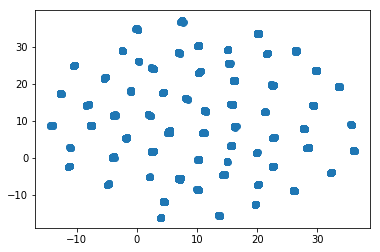

In [238]:
u = UMAP(metric='correlation', init='random')
coords = u.fit_transform(X)
x_coords, y_coords = list(zip(*coords))

plt.scatter(x_coords, y_coords)

array([0.11747217, 0.10624092])

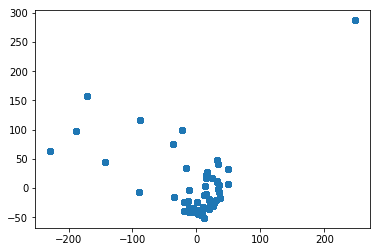

In [216]:
p = PCA(n_components=2)
coords = p.fit_transform(X)
display(p.explained_variance_ratio_)

x_coords, y_coords = list(zip(*coords))

plt.scatter(x_coords, y_coords)

In [240]:
p_var = PCA(n_components=30)
coords = p_var.fit_transform(X)
display(p_var.explained_variance_ratio_)

array([0.11747217, 0.10624092, 0.0720944 , 0.06253098, 0.05768335,
       0.04400041, 0.04115533, 0.03610823, 0.03276259, 0.03132476,
       0.03052362, 0.02614638, 0.02413015, 0.02186242, 0.02065265,
       0.01989648, 0.01764739, 0.0166747 , 0.01640953, 0.01565719,
       0.01378846, 0.01278914, 0.01217624, 0.01123474, 0.01031713,
       0.01002669, 0.00956637, 0.00877026, 0.00831939, 0.00802014])

In [242]:
import statsmodels.api as sm
from scipy import stats

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


                            OLS Regression Results                            
Dep. Variable:                norm_gr   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     21.51
Date:                Tue, 26 Feb 2019   Prob (F-statistic):               0.00
Time:                        01:12:57   Log-Likelihood:                -9623.6
No. Observations:                8081   AIC:                         1.966e+04
Df Residuals:                    7873   BIC:                         2.112e+04
Df Model:                         207                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5493      0.191      2.874

/anaconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 103 separate connected components using meta-embedding (experimental)
  n_components
/anaconda3/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


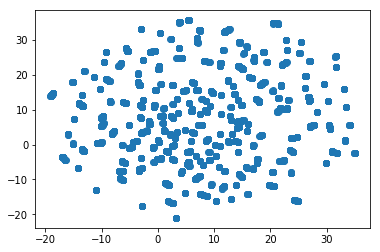

In [219]:
u_pca = UMAP()
coords = u_pca.fit_transform(p_var.transform(X))
x_coords, y_coords = list(zip(*coords))

plt.scatter(x_coords, y_coords)

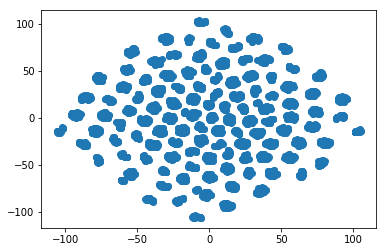

In [220]:
t = TSNE()
# pca to 20 dim before 
coords = t.fit_transform(PCA(n_components=30).fit_transform(X))
x_coords, y_coords = list(zip(*coords))
plt.scatter(x_coords, y_coords)